## Setup

In [1]:
!pip install shap
!pip install --upgrade xlrd
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 14.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 KB 5.5 MB/s eta 0:00:00
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninstalling xlrd-1.2.0:
      Successfully uninstalled xlrd-1.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# utilities
import os
import pandas as pd 
import numpy as np
import math
from pprint import pprint
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm 
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE, SMOTEN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score

import warnings
from IPython.display import clear_output 
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Download

In [4]:
# mode 
mode: str = 'ATP'
if mode == 'ATP': 
  data_dir: str = 'Mens'
else: 
  data_dir: str = 'Womens'

In [5]:
%cd ..

/


In [6]:
!mkdir data
%cd data
!git clone https://github.com/JeffSackmann/tennis_atp 
%cd tennis_atp

/data
Cloning into 'tennis_atp'...
remote: Enumerating objects: 3451, done.
remote: Total 3451 (delta 0), reused 0 (delta 0), pack-reused 3451
Receiving objects: 100% (3451/3451), 283.96 MiB | 23.76 MiB/s, done.
Resolving deltas: 100% (2687/2687), done.
Checking out files: 100% (177/177), done.
/data/tennis_atp


In [7]:
# get file names to upload
dir_idx: str = f"atp_matches_1968.csv"
df = pd.read_csv(dir_idx)
features: list = ['tourney_date', 'tourney_name', 'surface',
                  'winner_name', 'winner_hand', 'winner_ht', 
                  'loser_name', 'loser_hand', 'loser_ht', 'score', 'best_of', 'round',
                  'winner_rank', 'loser_rank']       
df = df[features]

for i in tqdm(range(1969, 2024)): 
  dir_idx: str = f"atp_matches_{i}.csv"
  df_add = pd.read_csv(dir_idx)          
  df_add = df_add[features]

  # create an average for the odds columns
  df_add.reset_index(inplace=True, drop=True)
  df = pd.concat([df, df_add])

df.dropna(inplace=True)

100%|██████████| 55/55 [00:01<00:00, 30.36it/s]


In [8]:
df['W'] = df['winner_name'] 
df['L'] = df['loser_name']

def get_game_total(score: str): 
  """get total number of games"""
  sets: list = str(score).split(' ')
  sets = [x.replace('RET', '').split('(')[0] for x in sets]
  games = [x.split('-') for x in sets]
  game_totals: int = 0
  for game in games: 
    try: 
      game_total = int(game[0]) + int(game[1])
      game_totals += game_total
    except ValueError: 
      continue
  return game_totals

df['total_sets'] = df['score'].apply(lambda x: get_game_total(x)) #df['score'].apply(lambda x: len(str(x).split(' '))) #
original_df = df.copy()

In [9]:
# create player id encoding
player_id = LabelEncoder()

player_arr: list = list(df['W'])
player_arr.extend(list(df['L']))
player_id.fit(player_arr)
df['W'] = player_id.transform(df['W'])
df['L'] = player_id.transform(df['L'])

# remove winner and loser names
df.drop(['winner_name', 'loser_name'], axis=1, inplace=True)

In [10]:
loc = LabelEncoder()
df['tourney_name'] = loc.fit_transform(df['tourney_name'])

surf = LabelEncoder()
df['surface'] = surf.fit_transform(df['surface'])

round_enc = LabelEncoder()
df['round'] = round_enc.fit_transform(df['round'])

hand_enc = LabelEncoder()
hand_arr: list = list(df['winner_hand'])
hand_arr.extend(list(df['loser_hand']))
hand_enc.fit(hand_arr)
df['winner_hand'] = hand_enc.transform(df['winner_hand'])
df['loser_hand'] = hand_enc.transform(df['loser_hand'])

In [11]:
df.drop(['score', 'tourney_date'], axis=1, inplace=True)

In [139]:
%cd ..
%cd ..
%cd content/drive/MyDrive/BetAIData/ATP/Mens

/
/
/content/drive/MyDrive/BetAIData/ATP/Mens


In [ ]:
!pip install pandas==1.3.0

In [14]:
df.to_csv("MensATP.csv")

## Model

In [154]:
df = pd.read_csv('MensATP.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df['RankD'] = abs(df['winner_rank'] - df['loser_rank'])
df['SetS'] = df['total_sets']
df = df[df['best_of'] == 5.0]

In [155]:
over_under = 19.5
df['Target'] = df["SetS"] > over_under
df['Target'] = df['Target'].astype(int)

In [156]:
df.dropna(inplace=True)
X = df.drop(['Target', 'SetS', 'best_of', 'total_sets'], axis=1)
y = df[['Target']]
orig_X = X

X, live_X = X[:-1000], X[-1000:]
y, live_y = y[:-1000], y[-1000:]

# oversample with SMOTE 
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.1, stratify=y)

model = XGBClassifier()
#scores = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
#print(scores)

model.fit(X_train.values, y_train.values)
preds = model.predict(X_test.values)
acc = roc_auc_score(preds, y_test)

# track parameters and accuracy 
current_acc = acc
depth = model.max_depth
subsample = model.subsample
gamma = model.gamma 
eta = model.learning_rate
tune: bool = False
best_model = model

if tune: 
  for depth in tqdm([2, 3, 5, 7, 8]): 
    for subsample in [0.4, 0.5, 0.7, 0.8]: 
      for gamma in [0.1, 0.2]: 
        for eta in [0.3, 0.1, 0.5]: 
          model = XGBClassifier(
              learning_rate=eta, 
              gamma=gamma, 
              subsample=subsample, 
              max_depth=depth
          )
          model.fit(X_train.values, y_train.values)
          preds = model.predict(X_test.values)
          acc = roc_auc_score(preds, y_test)
          if acc > current_acc: 
            current_acc = acc
            best_model = model

Target
0         24922
1         24922
dtype: int64


In [157]:
model = best_model
acc

0.9639798251721804

<BarContainer object of 12 artists>

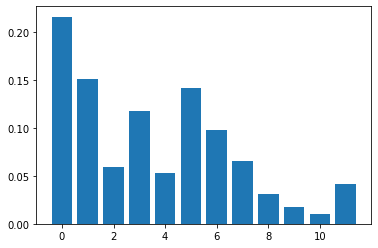

In [158]:
import matplotlib.pyplot as plt 
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

In [159]:
probs_pred = model.predict_proba(live_X.values)
confidence = 0.68

answers, probs = [], []
correct, incorrect, skipped = 0, 0, 0

for arr_prob, actual in zip(probs_pred, live_y.values): 
  prob = arr_prob[np.argmax(arr_prob)]
  pred = np.argmax(arr_prob)
  answers.append(pred == actual)
  probs.append(prob)
  if prob > confidence: 
    if pred == actual[0]: 
      correct += 1
    else: 
      incorrect += 1
  else: 
    skipped += 1

print(correct / (incorrect + correct))
print(skipped / len(live_y))

0.9734607218683652
0.058


In [160]:
results_df = pd.DataFrame([], columns=['Correct/Incorrect', 'Probs'])
results_df['Correct/Incorrect'] = answers
results_df['Probs'] = probs
results_df.to_csv('TennisBacktest.csv')

In [161]:
preds_live = model.predict(live_X.values)
roc_auc_score(preds_live, live_y)

0.4878419452887538

## Automated Run 

In [28]:
import requests 
from datetime import date
import datetime 
from pprint import pprint 

start_date = date.today()
end_date = str(start_date + datetime.timedelta(days=2))

raw_data = requests.get(f"https://api.api-tennis.com/tennis/?method=get_fixtures&APIkey=9374ff3201c64a522e9ddc3226d5f01f04006b5701f8f323c141f5651e3906b3&date_start={start_date}&date_stop={end_date}").json()

In [65]:
original_df[['winner_name', 'loser_name']].head(3)
original_df['winner_last_name'] = original_df['winner_name'].apply(lambda x: str(x).split(' ')[-1])
original_df['loser_last_name'] = original_df['loser_name'].apply(lambda x: str(x).split(' ')[-1])
original_df[['winner_last_name', 'loser_last_name']].head(3)

# full list of players
full_player_roster: list = []
full_player_roster.extend(original_df['winner_name'].to_list())
full_player_roster.extend(original_df['loser_name'].to_list())

In [66]:
# process the results and add necessary details on height, rank, hand
def search_player_stats(player_name: str):
  """find player along with their details in dataset"""
  found_name = None
  for name in full_player_roster: 
    if player_name.split('. ')[-1].lower() in name.lower(): 
      found_name = name
  player_df = original_df[(original_df['winner_name'] == found_name) | (original_df['loser_name'] == found_name)].tail(1)
  player_df.sort_values(by='tourney_date', ascending=True, na_position='first')
  # get stats for the player
  try: 
    if str(player_df['winner_name'].iloc[0]) == found_name: 
      hand, height, p_name, rank = str(player_df['winner_hand'].iloc[0]), str(player_df['winner_ht'].iloc[0]), str(player_df['winner_name'].iloc[0]), str(player_df['winner_rank'].iloc[0])
    else: 
      hand, height, p_name, rank = str(player_df['loser_hand'].iloc[0]), str(player_df['loser_ht'].iloc[0]), str(player_df['loser_name'].iloc[0]), str(player_df['loser_rank'].iloc[0])
    return hand, height, float(rank), p_name
  except IndexError: 
    return np.nan, np.nan, np.nan, np.nan

def search_tournament_stats(tournament_name: str): 
  """get stats for a particular tournament"""
  
  found_name = None
  for name in original_df['tourney_name'].to_list(): 
    if " ".join(tournament_name.split(' ')[1:]).lower() in name.lower(): 
      found_name = name
  tourn_df = original_df[original_df['tourney_name'] == found_name].tail(1)
  try: 
    return str(tourn_df['surface'].iloc[0]), found_name
  except IndexError: 
    return np.nan, np.nan

def run(): 
  container = []
  for game in tqdm(raw_data['result']): 
    if '/' in game['event_first_player']: 
      continue
    p1, p2 = game['event_first_player'], game['event_second_player']
    HA, HTA, RankA, P1 = search_player_stats(p1)
    HB, HTB, RankB, P2 = search_player_stats(p2)
    RankD = abs(RankA - RankB)
    surface_fet, location_fet = search_tournament_stats(game['tournament_name'])
    round_fet = game['tournament_round'].split('- ')[-1]
    container.append([location_fet, surface_fet, HA, HTA, HB, HTB, round_fet, RankA, RankB, P1, P2, RankD])
  return pd.DataFrame(data=container, columns=X_test.columns)

live_df_input = run()

100%|██████████| 428/428 [01:56<00:00,  3.67it/s]


In [162]:
live_df_input.dropna(inplace=True)

# OPTIONS: 
#1/64-finals
#1/32-finals
#Final

# fill in the blank inputs
for i, row in live_df_input.iterrows(): 
  if row['round'] == "": 
    round = input(f"Tournament Round of {row['W']} vs {row['L']}. Tournament: {row['tourney_name']}: ")
    live_df_input.at[i, 'round'] = round

In [71]:
# correct rounds in input dataframe
live_df_input['round'] = live_df_input['round'].apply(lambda x: 'R128' if x == '1/64-finals' else x)
live_df_input['round'] = live_df_input['round'].apply(lambda x: 'R64' if x == '1/32-finals' else x)
live_df_input['round'] = live_df_input['round'].apply(lambda x: 'R32' if x == '1/16-finals' else x)
live_df_input['round'] = live_df_input['round'].apply(lambda x: 'R128' if x == '1/64-finals' else x)
live_df_input['round'] = live_df_input['round'].apply(lambda x: 'F' if x == 'Final' else x)

In [72]:
# transform all categorical variables
live_df_input['tourney_name'] = loc.transform(live_df_input['tourney_name'])
live_df_input['round'] = round_enc.transform(live_df_input['round'])
live_df_input['surface'] = surf.transform(live_df_input['surface'])
live_df_input['W'] = player_id.transform(live_df_input['W'])
live_df_input['L'] = player_id.transform(live_df_input['L'])
live_df_input['winner_hand'] = hand_enc.transform(live_df_input['winner_hand'])
live_df_input['loser_hand'] = hand_enc.transform(live_df_input['loser_hand'])

In [163]:
print(f"Over-Under Games: {over_under}")

Over-Under Games: 19.5


In [164]:
%cd ..
%cd ..
%cd ..
%cd ..
%cd ..
%cd ..
%cd ..
%cd /content/

/content/drive/MyDrive/BetAIData/ATP
/content/drive/MyDrive/BetAIData
/content/drive/MyDrive
/content/drive
/content
/
/
/content


In [165]:
live_preds_prob = model.predict_proba(live_df_input.values)

# get predictions
live_predictions = [np.argmax(x) for x in live_preds_prob]
live_probabilities = [x[np.argmax(x)] for x in live_preds_prob]

live_df_preds = live_df_input.copy()
live_df_preds['prob'] = live_probabilities
live_df_preds['preds'] = live_predictions
live_df_preds['preds'] = live_df_preds['preds'].apply(lambda x: 'UP' if x else 'DOWN')
live_df_preds = live_df_preds[live_df_preds['prob'] > confidence]

live_df_preds['W'] = player_id.inverse_transform(live_df_preds['W'])
live_df_preds['L'] = player_id.inverse_transform(live_df_preds['L'])
live_df_preds[['W', 'L', 'preds', 'prob']].to_csv("TennisPreds.csv")
live_df_preds[['W', 'L', 'preds', 'prob']]

,W,L,preds,prob
1,Maxime Cressy,Albert Ramos,UP,0.869612
2,Alejandro Davidovich Fokina,Alexander Bublik,UP,0.865728
4,Grigor Dimitrov,Aslan Karatsev,UP,0.813255
5,Kyle Edmund,Jannik Sinner,UP,0.809557
8,Tomas Martin Etcheverry,Gregoire Barrere,UP,0.798109
...,...,...,...,...
320,Brandon Nakashima,Mackenzie Mcdonald,UP,0.765621
321,Enzo Couacaud,Hugo Dellien,UP,0.778293
344,Richard Gasquet,Cameron Norrie,UP,0.905824
382,Richard Gasquet,Cameron Norrie,UP,0.905824


## Run 

In [ ]:
# create prompt for selecting players
tour_names = {i: loc.inverse_transform([i])[0] for i in X['tourney_name'].unique()}
tour_names = sorted(tour_names.items(), key=lambda x:x[1])

# tournament round 
rounds = {i: round_enc.inverse_transform([i])[0] for i in X['round'].unique()}
rounds = sorted(rounds.items(), key=lambda x:x[1])

# surface
surfaces = {i: surf.inverse_transform([i])[0] for i in X['surface'].unique()}
surfaces = sorted(surfaces.items(), key=lambda x:x[1])

# players
P1 = list(df['W'].unique())
P2 = list(df['W'].unique())
P1.extend(P2)
players = {i: player_id.inverse_transform([i])[0] for i in set(P1)}
players = sorted(players.items(), key=lambda x:x[1])

# hands 
H1 = list(df['winner_hand'].unique())
H2 = list(df['loser_hand'].unique())
H1.extend(H2)
hands = {i: hand_enc.inverse_transform([i])[0] for i in set(H1)}
hands = sorted(hands.items(), key=lambda x:x[1])

### ------PROMPT------

# location
pprint(tour_names)
location_fet = int(input("Tour Name: "))
clear_output()

# round 
pprint(rounds)
round_fet = int(input("Round: "))
clear_output()

# surfaces
pprint(surfaces)
surface_fet = int(input("Surface: "))
clear_output()

# players
pprint(players)
P1 = int(input("Player 1: "))
P2 = int(input("Player 2: "))
clear_output()

# ranks
RankA = int(input("Player 1 Rank: "))
RankB = int(input("Player 2 Rank: "))
RankD = abs(RankA - RankB)
clear_output()

# hand
pprint(hands)
HA = float(input("Player 1 Hand: "))
HB = float(input("Player 2 Hand: "))
clear_output()

# height
HTA = float(input("Player 1 Height: "))
HTB = float(input("Player 2 Height: "))
clear_output()

# predict and return result
X_pred = [location_fet, surface_fet, HA, HTA, HB, HTB, round_fet, RankA, RankB, P1, P2, RankD]
y_pred = model.predict_proba([X_pred])
if np.argmax(y_pred) == 1: 
  print('Over: ', str(np.round(100*y_pred[0][np.argmax(y_pred)], 2)) + '%', f'Minimum Confidence: {65}.00%')
else:  
  print('Under: ', str(np.round(100*y_pred[0][np.argmax(y_pred)], 2)) + '%', f'Minimum Confidence: {65}.00%')

[(2, 'Adelaide'),
 (8, 'Amersfoort'),
 (9, 'Amsterdam'),
 (10, 'Amsterdam WCT'),
 (13, 'Antwerp'),
 (14, 'Aptos'),
 (17, 'Athens Olympics'),
 (18, 'Atlanta'),
 (19, 'Atlanta Olympics'),
 (20, 'Atlanta WCT'),
 (21, 'Atp Cup'),
 (22, 'Auckland'),
 (23, 'Australian Open'),
 (24, 'Australian Open-2'),
 (25, 'Aviles'),
 (26, 'Baltimore'),
 (27, 'Baltimore WCT'),
 (28, 'Bangkok'),
 (29, 'Barcelona'),
 (30, 'Barcelona Olympics'),
 (31, 'Barcelona WCT'),
 (32, 'Bari'),
 (33, 'Basel'),
 (34, 'Bastad'),
 (35, 'Beckenham'),
 (37, 'Beijing Olympics'),
 (38, 'Belgrade'),
 (41, 'Berlin'),
 (42, 'Bermuda'),
 (43, 'Birmingham'),
 (44, 'Birmingham WCT'),
 (45, 'Boca Raton'),
 (46, 'Boca West'),
 (47, 'Bogota'),
 (50, 'Bolzano'),
 (51, 'Bombay'),
 (52, 'Bordeaux'),
 (53, 'Boston'),
 (54, 'Bournemouth'),
 (55, 'Brasilia'),
 (57, 'Brighton'),
 (58, 'Brisbane'),
 (59, 'Bristol'),
 (60, 'Brussels'),
 (61, 'Bucharest'),
 (62, 'Budapest'),
 (63, 'Buenos Aires'),
 (65, 'Cagliari'),
 (69, "Cap D'Adge WCT"),
 (7

KeyboardInterrupt: ignored